# References

Smalldata_tools documentation: https://confluence.slac.stanford.edu/display/PSDM/smalldata_tools%3A+Analysis+tools+for+aligned+data

Generation of h5 files with smalldata_tools: https://confluence.slac.stanford.edu/display/PSDM/1.+Generation+of+the+small+data+hdf5+files


In [1]:
import numpy as np
import sys
import h5py
import tables
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cv2
import socket

from tqdm import tqdm

import sys
from pathlib import Path

import psana as ps

import ana_fun as ana

In [2]:
plt.style.use('dark_background')
#matplotlib.rcParams.keys()
plt.rcParams['figure.figsize'] = (10, 6)
plt.rc('font', size=12)
length = 8
width = 1.5
plt.rcParams['xtick.major.size'] = length
plt.rcParams['ytick.major.size'] = length
plt.rcParams['xtick.major.width'] = width
plt.rcParams['ytick.major.width'] = width

# Check smd files

In [3]:
run = 0
exp = 'xppXXXX'

if 'drp' in socket.gethostname():
    p = Path('/cds/data/drpsrcf/{}/{}/scratch/hdf5/smalldata'.format(exp[:3], exp))
else:
    p = Path('/cds/data/psdm/{}/{}/hdf5/smalldata/'.format(exp[:3], exp))
#     p = Path('/cds/data/psdm/{}/{}/scratch/ffb/hdf5/smalldata/'.format(exp[:3], exp))
print(p.exists())

it = p.glob('{}_Run{:04d}*'.format(exp,run))
try:
    f = next(it)
    print(f)
    print('\n')
except: print('No files found at this path.')

# only for example. COMMENT OR DELETE WHEN ANALYZING EXP DATA:
f = Path('/cds/data/psdm/xpp/xpptut15/hdf5/smalldata/data_examples/example_ccm_2d_scan.h5')

rr = tables.File(f).root
h5 = h5py.File(f)
print('\n'.join(h5.keys()))

False
No files found at this path.
Sums
UserDataCfg
alio_ccm_energy
damage
diodeU
ebeam
enc
epics
epicsUser
epix10k2M
epix10k2M_env
epix_2
epix_2_env
event_time
evr
fiducials
gas_detector
ipm2
ipm3
ipm_hx2
lightStatus
lombpm
lomdiode
scan
tt


In [41]:
rr.UserDataCfg.epix10k2M.run[:]

array([175])

# <font color='orange'> 1) Set and check filters </font>

In [5]:
# helper dict to find data in file
dataDict = {'i0': 'ipm3/sum',
            'fluo': 'epix_2/ROI_0_sum',
            'scattIm': 'epix10k2M/azav_azav',
            'spec': 'epix_2/droplet_spec_300_histogram',
            'specBins': 'UserDataCfg/epix_2/droplet__spec_300_bins',
            'xon': 'lightStatus/xray',
            'lon': 'lightStatus/laser',
            'corr': 'tt/ttCorr',
            'tt_fwhm': 'tt/FLTPOSFWHM',
            'tt_amp': 'tt/AMPL',
            'tt_corr': 'tt/ttCorr',
            'delay': 'enc/lasDelay',
#             'energy': 'epics/ccm_E'
            'energy': 'alio_ccm_energy'
           }
# comment: in general, epics/ccm_E is generally the variable to use for this.
# Here alio_ccm_energy is used because of a problem in the original variable.

filters =  {}
filters['i0'] = [3000,35000]
filters['tt_amp'] = [0.03,0.35]
filters['tt_fwhm'] = [40,230]
print('Filter selection:')
for key,value in filters.items():
	print('\t{} : {}'.format(key, value))
hist_bins = {key: 35 for key in filters.keys()}

Filter selection:
	i0 : [3000, 35000]
	tt_amp : [0.03, 0.35]
	tt_fwhm : [40, 230]


i0        :  Filter eliminates 12.2% of the shots
tt_amp    :  Filter eliminates 27.6% of the shots
tt_fwhm   :  Filter eliminates 23.7% of the shots


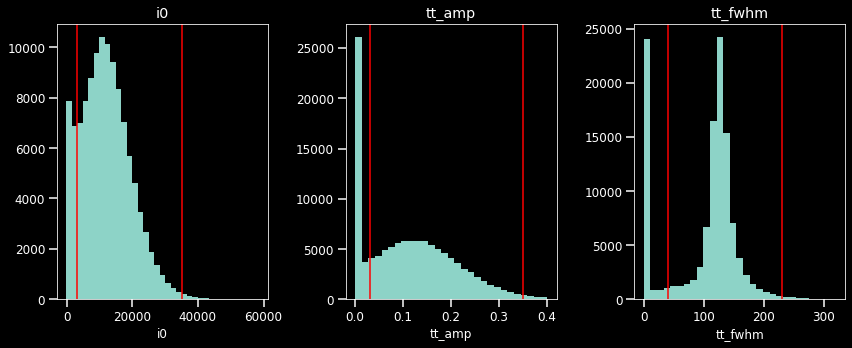

In [6]:
ncols = 3
nrows = len(filters)//ncols
fig, ax = plt.subplots(ncols=3, figsize=(12,5))
hist_bins['tt_fwhm'] = np.linspace(0,320,30)
hist_bins['tt_amp'] = np.linspace(0,0.40,30)
                           
for n, (key,value) in enumerate(filters.items()):
        ax[n].set_title(key)
        ax[n].hist(rr[dataDict[key]], bins=hist_bins[key]) 
        ax[n].set_xlabel(key)
        for ii in range(2):
            ax[n].axvline(value[ii], color='red')
        data = rr[dataDict[key]][:]
        filt = np.logical_and(data > value[0], data < value[1])
        r1 = sum(np.logical_not(filt))/filt.shape[0]
        print('{:10s}:  Filter eliminates {:.1%} of the shots'.format(key,r1))
plt.tight_layout()
plt.show()

# <font color='orange'> 2) Check sum of detector images </font>

Looking at the sum of all images in the run is a good way to make sure that there was no problem at any time during the run.

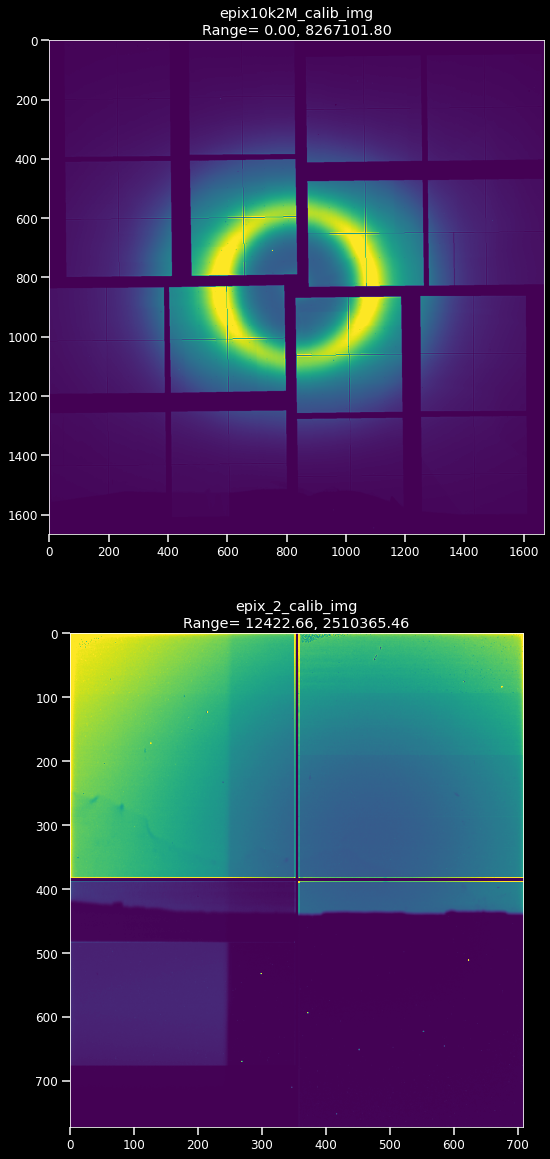

In [7]:
llim = 5 # percentile
ulim = 99

imageList = [el for el in list(rr.Sums._v_children) if (el.endswith('img') and not 'square' in el)]
_, ax = plt.subplots(figsize=(10,20), nrows=len(imageList))
if not isinstance(ax, np.ndarray):
    ax = [ax]

for ii, child in enumerate(imageList):
    im = rr.Sums[child][:]
    ax[ii].imshow(im, clim=(np.nanpercentile(im, llim),np.nanpercentile(im, ulim)))
    ax[ii].set_title('{}\nRange= {:.02f}, {:.02f}'.format(child, np.nanpercentile(im, llim), np.nanpercentile(im, ulim) ))
plt.show()

# <font color='orange'> 3) Q range for water ring normalization </font>

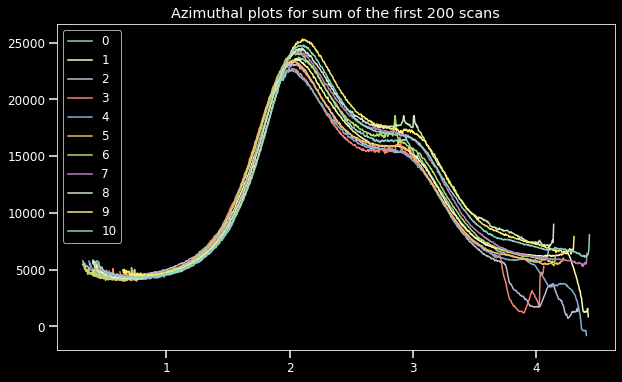

' Comment:\nThe number of curves in the graph below corresponds to the number of phi bins \nchosen for the aximuthal averaging.\n'

In [8]:
nScanPlot = 200

ims = np.sum(rr[dataDict['scattIm']][:nScanPlot][:nScanPlot],axis = 0)
imq = rr.UserDataCfg.epix10k2M.azav__azav_q[:]  #This shoudl be q
for i in range(ims.shape[0]):
    plt.plot(imq,ims[i,:], label = str(i))
plt.title('Azimuthal plots for sum of the first {} scans'.format(nScanPlot))
plt.legend()
plt.show()

""" Comment:
The number of curves in the graph below corresponds to the number of phi bins 
chosen for the aximuthal averaging.
"""

In [9]:
qMin = 1.
qMax = 2.2
qvalues = rr.UserDataCfg.epix10k2M.azav__azav_q[:]
q1 = np.where(qvalues >= qMin)[0][0]
q2 = np.where(qvalues <= qMax)[0][-1]
print('Using q from {} to {}'.format(q1,q2))
scattQ = np.nansum(rr[dataDict['scattIm']][:,:,q1:q2], axis = (1,2))

Using q from 137 to 376


In [10]:
scattQ # add filter template for water ring 

array([115374.47056671, 129781.68489639, 318883.75529949, ...,
       109220.08326701, 601640.93566953, 206636.29809764])

# <font color='orange'> 4) Diagnostics </font>

## Intensity - I0 correlation

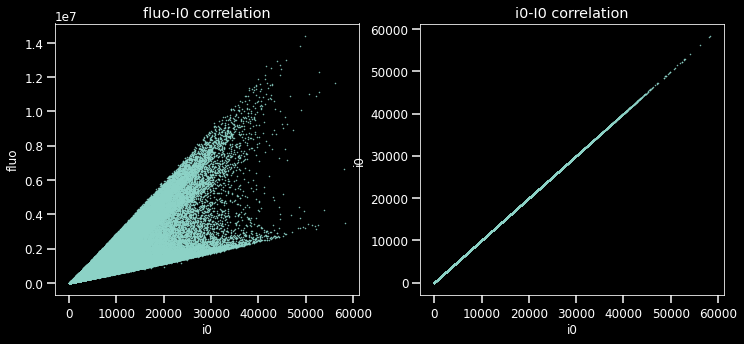

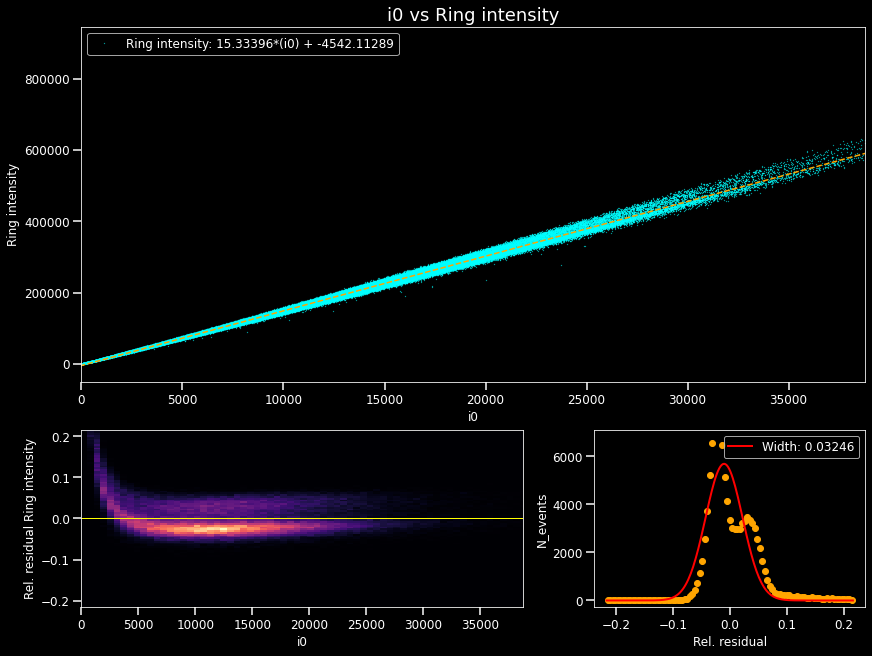

In [11]:
pltList = ['fluo','i0']
fig, ax = plt.subplots(ncols = len(pltList), figsize = (12,5))

for npl,pl in enumerate(pltList):
    ax[npl].plot(rr[dataDict['i0']][:], rr[dataDict[pl]][:][:], '.',  markersize=1)
    ax[npl].set_ylabel(pl)
    ax[npl].set_xlabel('i0')
    ax[npl].set_title('{}-I0 correlation'.format(pl))
plt.show()

# The lines below allow you to compare the scattering ROI (from smallData) to the summed scattering from azav
axs, fitRes, fitResG = ana.correlation_residual_plot(rr[dataDict['i0']], scattQ, 
                                                     labels=['i0','Ring intensity'], 
                                                     axs=None,
                                                     relative_residual=True, 
                                                     use_hist=False)

## Timetool

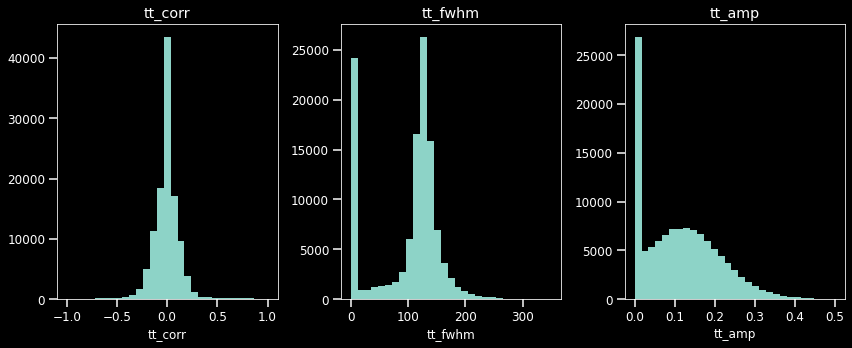

In [12]:
ttPL = {'tt_corr': np.linspace(-1,1,30),
        'tt_fwhm': np.linspace(0,350,30),
        'tt_amp':  np.linspace(0,0.5,30)
       }
if 'tt' in rr:
    fig, ax = plt.subplots(ncols=3, figsize=(12,5))
    ax = ax.ravel()
    for n,p in enumerate(ttPL):
        ax[n].set_title(p)
        ax[n].hist(rr[dataDict[p]], bins=ttPL[p]) 
        ax[n].set_xlabel(p)
    plt.tight_layout()
    plt.show() 

# <font color='orange'> 5) Bin data </font>

Generally the variable (motor) that is scanned is put in the `scan` field of the smalldata file. However, the fast laser delay is not properly captured and does not end up there. In case of a fast laser delay scan, the scan variable to use is `enc/lasDelay`. A few other motors are like that, please inquire the beamline staff or the data POC.

## Get the scan variables

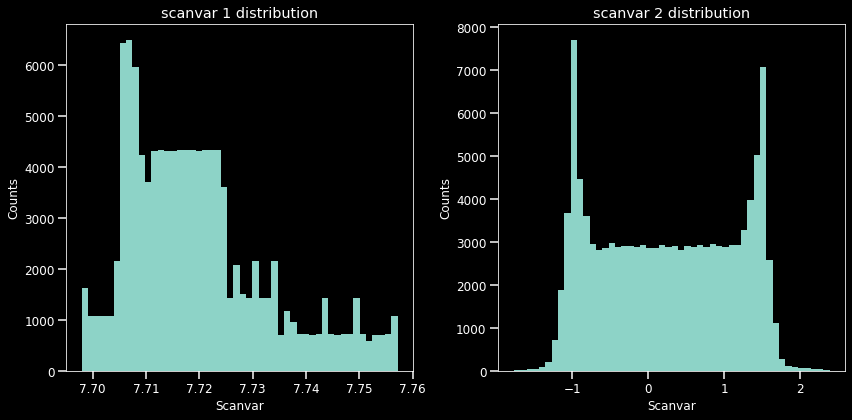

In [13]:
""" Get the scan variables """
scanvar1 = rr[dataDict['energy']][:]
scanvar2 = rr[dataDict['delay']][:] + rr[dataDict['tt_corr']][:] # apply timing tool correction to delay
scanvars = [scanvar1, scanvar2]

fig, ax = plt.subplots(figsize=(12,6), ncols=len(scanvars))
if not isinstance(ax, np.ndarray):
    ax = [ax]

for ii, sv in enumerate(scanvars):
    ax[ii].hist(sv, bins=50)
    ax[ii].set_title('scanvar {} distribution'.format(ii+1))
    ax[ii].set_xlabel('Scanvar')
    ax[ii].set_ylabel('Counts')
plt.tight_layout()
plt.show()

## Apply filter

In [14]:
filt = rr[dataDict['xon']][:] # with x-ray
lon = rr[dataDict['lon']][:] # with laser
filt_lon = np.logical_and.reduce([lon, filt])
filt_loff = np.logical_and.reduce([np.logical_not(lon), filt])
print('Laser on fraction: {:.1%}'.format(lon.sum()/lon.shape[0]))

""" Apply all filters """
for n, (key,value) in enumerate(filters.items()):
    data = rr[dataDict[key]][:]
    filt_lon = np.logical_and.reduce([filt_lon, data>value[0], data<value[1]])
    if 'tt' in key: 
        continue # do not apply time tool filters to laser off
    filt_loff = np.logical_and.reduce([filt_loff, data>value[0], data<value[1]])

r1 = sum(filt_lon)/filt_lon.shape[0]
r2 = sum(filt_loff)/filt_loff.shape[0]
print('After filtering: \n\t{:.1%} of laser on shots \n\t{:.1%} of laser off shots'.format(r1,r2))

Laser on fraction: 85.7%
After filtering: 
	69.2% of laser on shots 
	12.5% of laser off shots


## Build dictionary for binning

In [16]:
""" Create a dictionary (or pandas dataframe) with the relevant variables """
intensity = rr[dataDict['fluo']][:] # Signal
inorm = scattQ # normalization (water ring intensity in example)

data_to_bin = {
    'scanvar1': scanvar1[filt_lon],
    'scanvar2': scanvar2[filt_lon],
    'intensity': intensity[filt_lon],
    'i0': rr[dataDict['i0']][filt_lon],
    'inorm':inorm[filt_lon]
}

data_to_bin_loff = {
    'scanvar1': scanvar1[filt_loff],
    'scanvar2': scanvar2[filt_loff],
    'intensity': intensity[filt_loff],
    'i0': rr[dataDict['i0']][filt_loff],
    'inorm':inorm[filt_loff]
}

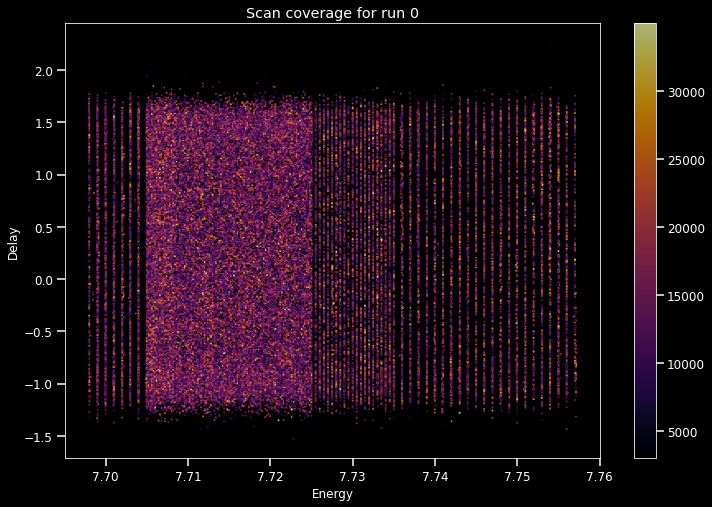

In [17]:
fig, ax = plt.subplots(ncols=1, figsize=(12,8))
plt.scatter(data_to_bin['scanvar1'], data_to_bin['scanvar2'], c=data_to_bin['i0'], s=1, alpha=0.7, cmap='inferno')
plt.xlabel('Energy')
plt.ylabel('Delay')
plt.title('Scan coverage for run {}'.format(run))
plt.colorbar()
plt.show()

## N-dimensional binning

Bin along multiple axis.

In [18]:
t_binCenters = np.arange(-1.5,2,0.05)
e_binCenters = np.linspace(7.695,7.76,50)
# e_binCenters = np.unique(data_to_bin['scanvar'])

binned_data, binEdges = ana.bin_data_ndim(data_to_bin, 
                                 bin_keys=['scanvar1', 'scanvar2'], 
                                 bin_centers=[e_binCenters, t_binCenters])

binned_data_loff, binEdge_loff = ana.bin_data_ndim(data_to_bin_loff, 
                                 bin_keys=['scanvar1', 'scanvar2'], 
                                 bin_centers=[e_binCenters, t_binCenters])
print('\n'.join(binned_data.keys()))

counts
scanvar1_bin
scanvar2_bin
scanvar1
scanvar2
intensity
i0
inorm


In [19]:
""" Normalize data """
binned_data['inorm'].shape
ints = binned_data['intensity']/binned_data['inorm']
ints = ints[::-1,:]

/cds/sw/ds/ana/conda1/inst/envs/ana-4.0.43-py3/lib/python3.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


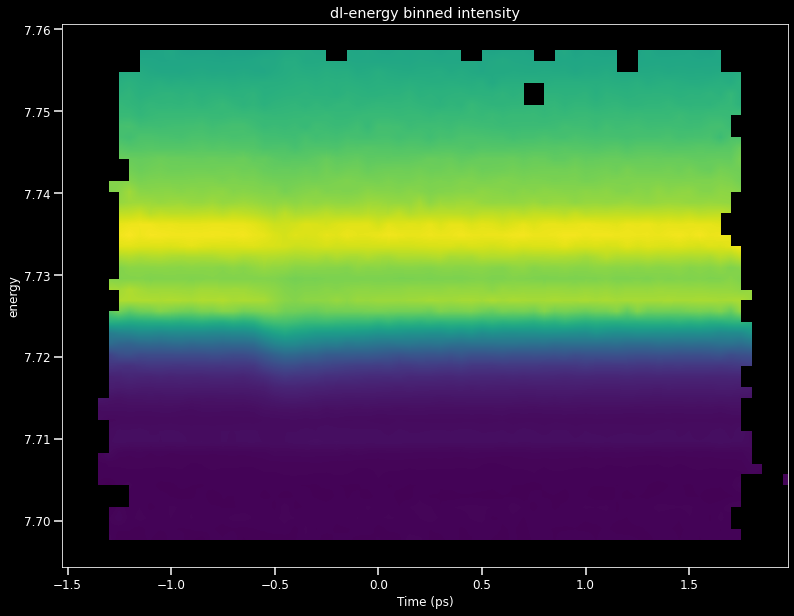

In [20]:
x = binned_data['scanvar2_bin']
y = binned_data['scanvar1_bin']
dx = (x[1]-x[0])/2.
dy = (y[1]-y[0])/2.
extent = [x[0]-dx, x[-1]+dx, y[0]-dy, y[-1]+dy]

fig, ax = plt.subplots(figsize=(13,10))
ax.imshow(ints, extent=extent, aspect='auto', interpolation='bilinear')
# ax.imshow(binned_data['inorm'].T, aspect='auto', extent=extent)
ax.set_title('dl-energy binned intensity')
ax.set_xlabel('Time (ps)')
ax.set_ylabel('energy')
plt.show()

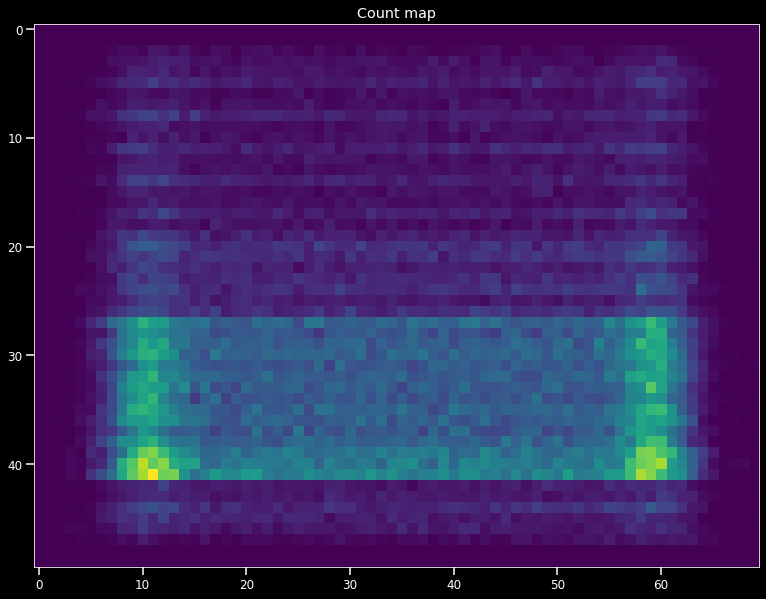

In [21]:
fig, ax = plt.subplots(figsize=(13,10))
plt.imshow(binned_data['counts'][::-1,:], aspect='auto', interpolation=None)
ax.set_title('Count map')
plt.show()

/cds/sw/ds/ana/conda1/inst/envs/ana-4.0.43-py3/lib/python3.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: Mean of empty slice
/cds/sw/ds/ana/conda1/inst/envs/ana-4.0.43-py3/lib/python3.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: Mean of empty slice
/cds/sw/ds/ana/conda1/inst/envs/ana-4.0.43-py3/lib/python3.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: Mean of empty slice
/cds/sw/ds/ana/conda1/inst/envs/ana-4.0.43-py3/lib/python3.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: Mean of empty slice


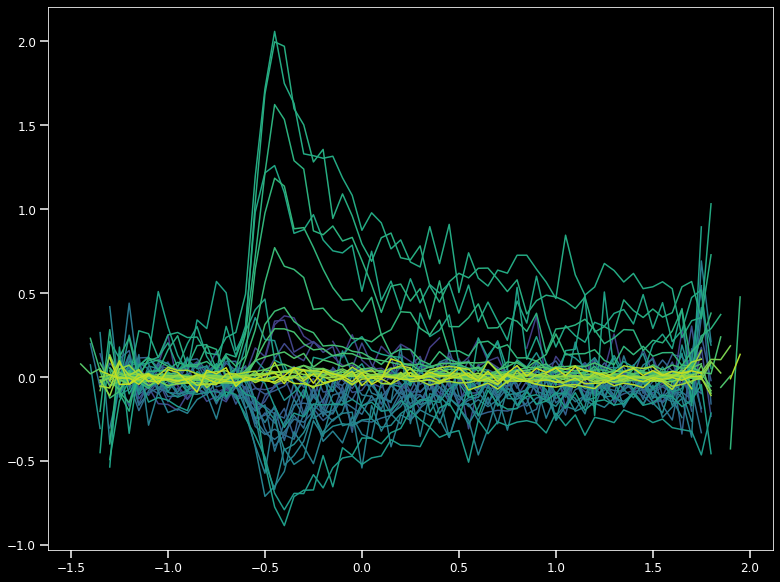

In [22]:
colors = plt.cm.viridis(np.linspace(0.15,0.95,binned_data['scanvar1_bin'].size))
offset = np.arange(binned_data['scanvar2_bin'].size)*0

fig, ax = plt.subplots(figsize=(13,10))
for ii, dat in enumerate(binned_data['scanvar1_bin']):
    y = ints[ii,:]
    y = y-np.nanmean(y[:10])
    plt.plot(binned_data['scanvar2_bin'], y+offset[ii], color=colors[ii])
plt.show()

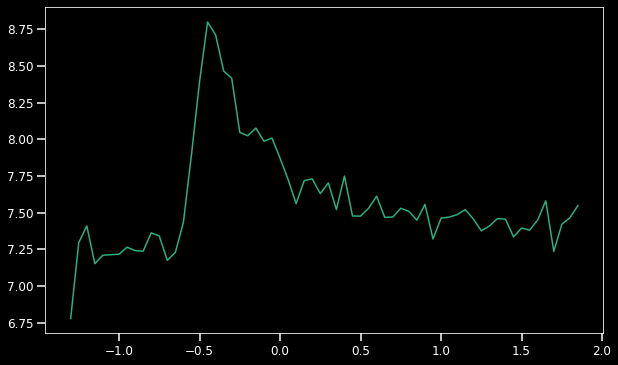

In [22]:
ii = 30
plt.plot(binned_data['scanvar2_bin'], ints[ii,:], color=colors[ii])
plt.show()

### Save binned data to hdf5 files

Can save arbitrary sized data

In [23]:
fname = f'binned/r{run}_lon.h5'
ana.dict_to_h5(binned_data, fname)

fname = f'binned/r{run}_loff.h5'
ana.dict_to_h5(binned_data_loff, fname)

# open file for read
# tt = tables.File(fname).root